# Physics 231: Final Project
## Adiabatic Evolution of the Anharmonic Oscillator

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [2]:
# IN SI UNITS
# const_hbar = 1.0545718 * 1e-34
# const_omega = 1e+16
# const_mass = 9.10938356 * 1e-31

const_hbar = 1
const_omega = 1
const_mass = 1

### Defining the Ladder Operators in the Harmonic Oscillator Basis

__Note:__ n sets the size of the Hilbert Space spanned by the basis states $\{|0\rangle,|1\rangle,...,|n-1\rangle\}$.

In [3]:
def op_a(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i][i+1] = np.sqrt(i+1)
    return mat

def op_adag(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i+1][i] = np.sqrt(i+1)
    return mat

def op_n(n):
    a = op_a(n)
    adag = op_adag(n)
    mat = np.dot(adag,a)
    return mat

In [4]:
a = op_a(5)
b = op_adag(5)
print(np.dot(a,b)-np.dot(b,a)) #expect [a,adag] = 1
print(op_n(5))

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 4.]]


__Note:__ The error in the last row is a result of the fact that the originally infinite Hilbert Space has been truncated.

### Defining the x,p in terms of Dagger Operators

$$x = \sqrt{\frac{\hbar}{2m\omega}}(a+a^+)$$

$$p = -i\sqrt{\frac{m\omega\hbar}{2}}(a-a^+)$$

#### We will be setting $\hbar = m = \omega = 1$ 

In [5]:
def op_x(n):
    mat = np.sqrt(const_hbar/(2*const_mass*const_omega))*(op_a(n) + op_adag(n))
    return mat

def op_p(n):
    mat = (-1j)*np.sqrt((const_hbar*const_mass*const_omega)/2)*(op_a(n) - op_adag(n))
    return mat

In [6]:
x = op_x(5)
p = op_p(5)
print(np.imag(np.dot(x,p)-np.dot(p,x))) # expect [x,p] = ihbar

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]


#### Test: Is $x^2$ the same from definition of x and dagger operators

In [7]:
# FROM DAGGER OPERATORS
a = op_a(5)
adag = op_adag(5)
# x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.eye(5)+2*op_n(5))) # using aa^+ = 1 + n
x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.dot(adag,a)+np.dot(a,adag)))
x2

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

In [8]:
# FROM DEFINITION OF x
x = op_x(5)
x2_test = np.dot(x,x)
x2_test

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

__Result:__ Both are same, as expected. Life is good.

In [9]:
def op_x2(n):
    x = op_x(n)
    mat = np.dot(x,x)
    return mat

def op_p2(n):
    p = op_p(n)
    mat = np.dot(p,p)
    return mat

def op_x3(n):
    x = op_x(n)
    x2 = op_x2(n)
    mat = np.dot(x,x2)
    return mat

def op_x4(n):
    x2 = op_x2(n)
    mat = np.dot(x2,x2)
    return mat

### Defining the Hamiltonians in terms of Dagger Operators

$$H_i = \frac{p^2}{2m} + \frac{m\omega^2 x^2}{2}$$

$$H_f = \frac{p^2}{2m} + \frac{m\omega^2(x-b)^2}{2} + \lambda (x-b)^4 $$

In [10]:
def op_Hi(n):
    x2 = op_x2(n)
    p2 = op_p2(n)
    mat = 0.5*(const_mass*const_omega**2*x2 + p2/const_mass) 
    return mat
    
def op_Hf(n, b, lam): # complete the definition with b
    b = b*np.eye(n)
    x = op_x(n)
    x2 = np.dot(x-b,x-b)
    x4 = np.dot(x2,x2)
    p2 = op_p2(n)
    mat = 0.5*(const_mass*const_omega**2*x2 + p2/const_mass) + lam*x4
    return mat 

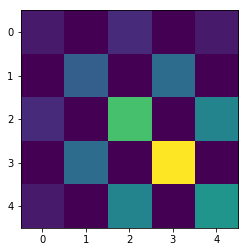

In [11]:
op_Hf(5,0,1)
plt.imshow(np.real(op_Hf(5,0,1)))

### Quantum Adiabatic Evolution

We want to evolve the system from the initial $H_i$ to the final $H_f$ using the Adiabatic Theorem such that:

$$ H(t, T, \lambda, b) = H_i \Big(1 - \frac{t}{T}\Big) + H_f(\lambda, b) \frac{t}{T} $$

where $t \in [0,T]$.

To do so, we will time evolve the ground state $|0\rangle$ of the SHO using the time dependent Hamiltonian above. 

In [12]:
def state_n(dim, n):
    vec = np.zeros(dim)
    vec[n] = 1
    return vec

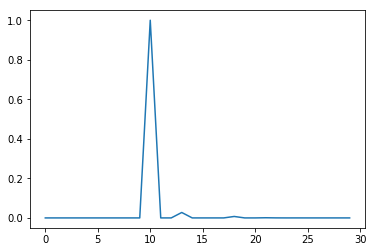

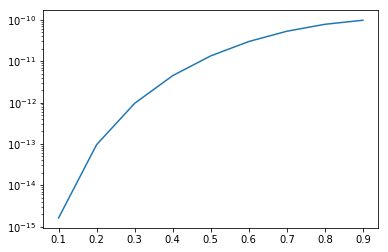

In [21]:
lam = 0.01
b = 0
dim = 30

T_range = []
prob = []

psi_i = state_n(dim, 0)

Hf = op_Hf(dim, b, lam)
eigval, eigvec  = np.linalg.eig(Hf)
psi_f = eigvec[np.argmin(eigval)]
plt.plot(np.abs(psi_f))
plt.show()

T_ar = np.arange(0.1,1,0.1)
for T in T_ar:
    
    time = np.linspace(0,T,1000)
    step = T/1000
    psi = psi_i + 1j*np.zeros(dim)
    for t in time:
        H_t = op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T)
        # H_t = op_Hi(dim) + op_Hf(dim, b, lam)
        # H_t = op_Hf(dim, b, lam)*(1-t/T) + op_Hf(dim, b, lam)*(t/T)
        # print(np.transpose(np.conj(H_t)) - H_t)
        del_psi = -1j*np.dot(H_t,psi)*step
        psi += del_psi
        # print(np.dot(np.conj(psi),psi))
            
    overlap = np.dot(psi_f,psi)

    T_range.append(T)
    prob.append(np.dot(np.conj(overlap),overlap))
    
plt.semilogy(T_range, prob)
#plt.ylim(-2, 2)
plt.show()

### Checking the enerygy gap

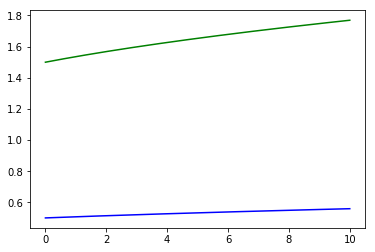

In [28]:
lam = 0.1
T = 10
e1 = []
e2 = []
    
time = np.linspace(0,T,1000)
step = T/1000
psi = psi_i + 1j*np.zeros(dim)
for t in time:
    H_t = op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T)
    eigval, eigvec  = np.linalg.eig(H_t)
    eigval = np.sort(eigval)
    e1.append(eigval[0])
    e2.append(eigval[1])
        
plt.plot(time, e1, color = 'b')
plt.plot(time, e2, color = 'g')

### Other Failed Attempts

In [106]:
# T = 10
lam = 1e+120
b = 0
time = np.arange(0,10,0.01)
dim = 40

T_range = []
prob1 = []
prob2 = []

psi_i = state_n(dim, 0)
H_t = 1j*np.zeros((dim,dim))

Hf = op_Hf(dim, b, lam)
eigval, eigvec  = np.linalg.eig(Hf)
psi_f = eigvec[np.argmin(eigval)]
print("psi_f",psi_f)

# T_ar = np.logspace(-50,-37,100)
T_ar = np.arange(0,10,1)
for T in T_ar:
    
#     time = np.arange(0,T,0.0001)
#     for t in time:
#         H_t += (op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T))*0.1
    #print(np.real(H_t))
    
#     time = np.arange(0,T,0.01)
#     for t in time:
#         mat = (op_Hi(dim)*(1-t/T) + op_Hf(dim, b, lam)*(t/T))*0.1
#         if (t == 0):
#             H_t = mat
#         else:
#             H_t = np.dot(mat,H_t)
            
        
    #print(np.real(H_t))

    H_t_2 = op_Hi(dim)*(T/2) + op_Hf(dim, b, lam)*(T/2)
    #print(np.real(H_t_2))
    
    # psi_T1 = np.dot(expm(-1j*H_t),psi_i)
    psi_T2 = np.dot(expm(-1j*const_hbar*H_t_2),psi_i)
    #print("state time",psi_T2)
    #print(np.absolute(psi_T))
    
    # overlap1 = np.dot(psi_f,psi_T1)
    #print(overlap1)
    overlap2 = np.dot(psi_f,psi_T2)
    
    #print("overlap",overlap2)
    #print(np.dot(np.conj(psi_T2), psi_T2))
    T_range.append(T)
    #prob1.append(np.linalg.norm(psi_T1))
    #prob2.append(np.linalg.norm(psi_T2))
    #prob1.append(np.dot(np.conj(overlap1),overlap1))
    prob2.append(np.dot(np.conj(overlap2),overlap2))

psi_f [ 5.92558916e-01+0.00000000e+00j -3.28923318e-01+7.70371978e-33j
  1.53133529e-01-5.77778983e-34j -2.80871103e-08-7.85874755e-26j
  1.88317734e-08-2.32573983e-26j -1.70006983e-07+5.02716879e-25j
 -2.64379400e-02-1.94846620e-34j -2.26789941e-06-7.07591889e-24j
 -6.68745757e-02+4.23704588e-33j  6.31841810e-06-9.23955474e-23j
  1.35337777e-01+7.70371978e-33j  2.34572001e-04-4.19792320e-21j
 -1.84335943e-01+1.30963236e-32j  3.38262027e-03-2.98175183e-19j
  2.17586136e-01-6.00890143e-32j -7.44800746e-04-4.22547788e-19j
 -2.37817265e-01+5.85482703e-32j -1.20869503e-02-4.20494777e-20j
  2.47109938e-01-1.46939121e-31j  1.51959781e-02-3.54347019e-20j
 -2.47358318e-01+1.23259516e-31j -1.22619433e-02+5.14510364e-19j
  2.39757767e-01+9.86076132e-32j  6.39493621e-03-3.54141122e-18j
 -2.25622663e-01-2.46519033e-32j  3.35659646e-03+1.67422595e-18j
  1.89170037e-01+2.68705746e-30j  6.83150118e-02-2.90940783e-19j
 -1.81614424e-01+4.93038066e-31j -2.40612073e-02+1.87665491e-19j
  1.53346638e-01+1.

OverflowError: cannot convert float infinity to integer

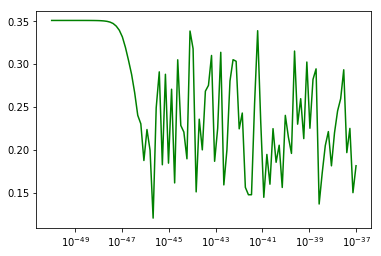

In [101]:
#plt.plot(T_range, prob1, color = 'b')
plt.plot(T_range, prob2, color = 'g')
plt.xscale('log')
plt.show()

In [36]:
eigval, eigvec  = np.linalg.eig(Hf)
eigval

array([48.44674207+0.j,  0.5072562 +0.j, 37.85987546+0.j,  2.5908458 +0.j,
       47.52905502+0.j, 31.50675541+0.j,  4.77491312+0.j,  7.04832688+0.j,
       27.67056   +0.j,  9.40269231+0.j,  1.53564828+0.j, 24.91850178+0.j,
       11.83140079+0.j,  3.67109494+0.j, 36.89494242+0.j, 22.19510504+0.j,
       14.32908402+0.j, 19.5141654 +0.j,  5.90102667+0.j, 16.89127572+0.j,
       30.45004579+0.j,  8.21583781+0.j, 10.60811357+0.j, 26.42676103+0.j,
       13.07191784+0.j, 23.55880521+0.j, 20.84873702+0.j, 18.19535846+0.j,
       15.60236405+0.j, 16.97779189+0.j])

In [109]:
state_n(5, 0) + 1j*np.zeros(5)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [ ]:
psi_i = [1,0,0,0,0]
psi_T = np.dot(expm(-1j*H_t),psi_i)
print(psi_T)
print(np.absolute(psi_T))

In [ ]:
mat = expm(-1j*H_t)
np.dot(np.transpose(np.conj(mat)),mat) - np.eye(5)

In [ ]:
np.absolute([3+4j])

In [ ]:
np.linalg.norm([3+4j, 4j])

In [ ]:
state_n(10,0)

In [ ]:
dim = 10
lam = 0.1
psi_f = psi_i + lam*(-np.sqrt(2)/8)*(3*state_n(dim, 2) + np.sqrt(3)*state_n(dim, 4))
np.dot(psi_f,psi_f)

#### Sanity Checks

In [ ]:
x = op_x(5)
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5)
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) 
vec1 = np.asarray([0,1,0,0,0])
vec2 = np.asarray([0,0,1,0,0])
(0.6)*(0.8)*(np.dot(vec1,np.dot(x,vec2)) + np.dot(vec2,np.dot(x,vec1)))

In [ ]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

In [ ]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))